# Lab 2 Task 5
Implemented from article: <br>
https://levelup.gitconnected.com/building-stable-diffusion-from-scratch-using-python-f3ebc8c42da3

In [39]:
"""
%pip install einops
"""

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

# misc
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import functools
import math
import numpy as np
from einops import rearrange # For rearranging tensors

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda:0


In [40]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t, y=y)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

sigma = 25.0
marginal_prob_std = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
# Gausian random features
# Used for time-embedding. When score function is dependent on time,
# Time is essentially many sinusoidal features. 
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale = 30):
        super().__init__()
        # fixed during opt => no training
        self.W = nn.Parameter(torch.randn(embed_dim//2) * scale, requires_grad=False)

    def forward(self, x):
        # project the tensor into sine and cosine components (concatenated for output)
        # see article for more info
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat( [torch.sin(x_proj), torch.cos(x_proj)], dim=1)

In [ ]:
# FC later: output -> feature map
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Slightly bewildering but simply casts 2D tensor -> 4D tensor
        # This is to make it suitable as a feature map for later layers
        return self.dense(x)[..., None, None] 

In [ ]:
# Sampler 
# Sampling: Random img -> guess noise -> remove said noise -> repeat
# Can be done in several ways. Here with the Euler-Murayama method (same as article)
def em_sampler(score_model, marginal_prob_std, diff_coef, 
               batch_size = BATCH_SIZE, num_steps = 500, y_tensor = None):
    eps = 1e-3
    x_shape = (1,28,28)

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:,None,None,None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diff_coef(batch_time_step)
            mean_x = x + (g**2)[:,None,None,None] * score_model(x, batch_time_step, y=y_tensor) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.rand_like(x)
    
    return mean_x

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        super(CrossAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        if self.self_attn:
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K) 
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  
        return ctx_vecs
    

    
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        x = self.attn_self(self.norm1(x)) + x
        x = self.attn_cross(self.norm2(x), context=context) + x
        x = self.ffn(self.norm3(x)) + x
        return x



class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.transformer(x, context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x + x_in

In [ ]:
class UNet_Tranformer(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        super().__init__()
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [42]:
continue_training = True
if not continue_training:
    print("Creating new model")
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std))
    score_model = score_model.to(device)
else:
    print("Continuing on existing model")

n_epochs =   100 
batch_size =  1024 
lr = 10e-4

dataset = torchvision.datasets.MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    if epoch % 10 == 0: print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt_unet_sdiff.pth')

Continuing on existing model


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\hanne\AppData\Local\Temp\ipykernel_11504\3402354398.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 55.895779:   1%|          | 1/100 [00:06<11:21,  6.88s/it]

0 Average Loss: 55.895779 lr 9.8e-04


Average Loss: 21.483274:  11%|█         | 11/100 [01:16<10:16,  6.92s/it]

10 Average Loss: 21.483274 lr 8.0e-04


Average Loss: 19.951245:  21%|██        | 21/100 [02:25<09:19,  7.09s/it]

20 Average Loss: 19.951245 lr 6.5e-04


Average Loss: 18.848445:  31%|███       | 31/100 [03:37<08:10,  7.10s/it]

30 Average Loss: 18.848445 lr 5.3e-04


Average Loss: 18.333958:  41%|████      | 41/100 [04:52<07:20,  7.46s/it]

40 Average Loss: 18.333958 lr 4.4e-04


Average Loss: 17.748241:  51%|█████     | 51/100 [06:07<06:08,  7.51s/it]

50 Average Loss: 17.748241 lr 3.6e-04


Average Loss: 17.206880:  61%|██████    | 61/100 [07:16<04:32,  6.98s/it]

60 Average Loss: 17.206880 lr 2.9e-04


Average Loss: 17.141042:  71%|███████   | 71/100 [08:25<03:20,  6.91s/it]

70 Average Loss: 17.141042 lr 2.4e-04


Average Loss: 16.989688:  81%|████████  | 81/100 [09:33<02:09,  6.81s/it]

80 Average Loss: 16.989688 lr 2.0e-04


Average Loss: 16.799039:  91%|█████████ | 91/100 [10:41<01:01,  6.81s/it]

90 Average Loss: 16.799039 lr 2.0e-04


Average Loss: 16.686201: 100%|██████████| 100/100 [11:43<00:00,  7.03s/it]


In [43]:
ckpt = torch.load('ckpt_unet_sdiff.pth', map_location=device)
score_model.load_state_dict(ckpt)

digit = 9 
sample_batch_size = 64
num_steps = 250
sampler = em_sampler
# score_model.eval()

samples = sampler(score_model,
        marginal_prob_std,
        diffusion_coeff,
        sample_batch_size,
        num_steps=num_steps,
        y_tensor=digit*torch.ones(sample_batch_size, dtype=torch.long))

C:\Users\hanne\AppData\Local\Temp\ipykernel_11504\3402354398.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\hanne\AppData\Local\Temp\ipykernel_11504\3402354398.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 250/250 [00:01<00:00, 168.73it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


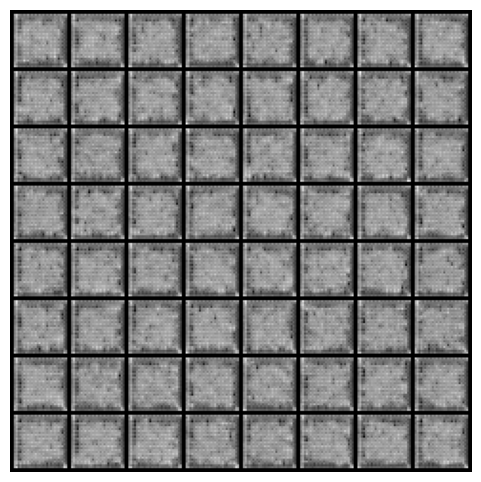

In [44]:
# samples = samples.clamp(0.0, 1.0)
samples = samples / torch.max(samples)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.0)
plt.show()